# Column Analysis Evaluation

Reducing the tableschema from more than 100 columns to fewer than 10 columns is one of the critical parts of this thesis. SAP tables - or tables from business information systems in general - have the common characteristics to hold wide and sparse tables **(Referenz auf Plattner In Memory Datenbanken einfügen)**.  The following notebook presentates the development of a tool to reduce the dimension size of a tableschema given a question, so that only relevant columns will be displayed to the sql generating model.

| FIELD_TECHNICAL | FIELD_DESCRIPTIVE                                   | FIELD_GLOVE                      | DDIC_POSITION | SAP_POSITION |
|-----------------|-----------------------------------------------------|----------------------------------|---------------|--------------|
| RCOMP           | company                                             | company                      | 11            | 12           |
| BUKRS           | company code                                        | company code              | 0             | 2            |
| BUTXT           | name of company   code or company                   | company name              | 2             | 3            |
| XPROD           | indicator   productive company code                 | production company      | 29            | 33           |
| FDBUK           | cash management and   forecast company code         | managed cash company | 1             | 23           |
| XGSBE           | indicator business   area financial statements r... | area business        | 27            | 30           |
| LAND1           | country key                                         | country                     | 4             | 5            |
| KKBER           | credit control area                                 | area control credits | 24            | 27           |
| XKKBI           | indicator can   credit control area be overwritten  | area control            | 54            | 59           |
| ADRNR           | address                                             | address                      | 12            | 13           |

In [1]:
import json
import os
import pandas as pd
import numpy as np
import timeit
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import Markdown, display
from preprocessing.column_analysis import Preprocessor

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Johannes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Johannes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Johannes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# general config
config_general_path = 'C:/Users/Johannes/Desktop/Bachelorarbeit/40_Entwicklung/SAP2SQL/data/config_general.json'
with open(config_general_path) as cfile:
    config_general = json.load(cfile)

config_path = config_general['config_columnanalysis_path'] # ca config    
with open(config_path) as cfile:
    config_ca = json.load(cfile)
    config_ca['data_dir'] = config_general['data_dir']

config_path = config_general['config_columnanalysis_evaluator_path'] # ca config  
with open(config_path) as cfile:
    config_eval = json.load(cfile)

In [3]:
ca = Preprocessor(config_ca)

In [12]:
ca.dynamic_tableschema('Which business area is deposited in document number 1234502930?', 'VBAK', size=4)

,FIELD_TECHNICAL,FIELD_DESCRIPTIVE,FIELD_GLOVE,FIELD_GLOVE_TOK,FIELD_GLOVE_LONG,FIELD_GLOVE_LONG_TOK,DDIC_POSITION,SAP_POSITION
0,GSBER,business area,business area,"[business, area]",business area,"[business, area]",18,24
1,KOKRS,controlling area,area,[area],area,[area],47,59
2,DNO,diversion number,number,[number],number,[number],119,141
3,VGBEL,document number of the reference document,document reference number,"[document, reference, number]",document reference number,"[document, reference, number]",62,75
4,VBELN,sales document,sales document,"[sales, document]",document sales,"[document, sales]",0,2


In [4]:
class PreprocessorEvaluator():
    
    def __init__(self, preprocessor, config):
        self.preprocessor = preprocessor
        self.config = config
        
        self.validation_data_path = self.config['validation_data_path']
        self.metrics = self.config['metrics']
        self.beta = self.config['beta']
        self.alpha = self.config['alpha']
        self.dyn_tablesize = self.config['dyn_tablesize']
        self.categories = self.config['categories']
        self.save_to = self.config['save_to']
        self.figsizes = self.config['figsizes']
        self.bootstrap = self.config['bootstrap']
        self.verbose = self.config['verbose']
        self.histogram_bins = self.config['histogram_bins']
        self.colors = self.config["colors"]
        
        self.font = self.config['font']
        rc('font', **self.font)
        rc('text', usetex=True)
        self.fontsizes = self.config['fontsizes']
        self.picture_format=self.config['picture_format']
        self.dpi = self.config['dpi']
        
        if self.save_to:
            cwd = os.getcwd()
            os.chdir(self.preprocessor.data_dir)
            if not os.path.isdir(os.path.join(self.preprocessor.data_dir, self.save_to)):
                os.mkdir(self.save_to)
            os.chdir(cwd)
            
    def eval_all(self, display=False):
        
        if not display:
            plt.ioff()
        
        print("Evaluating the preprocessor for column analysis.")
        start = timeit.default_timer()
        
        print("Evaluating range of columns...")
        self.column_overview()
        print("Evaluating details of columns...")
        self.column_details()
        print("Evaluating wrong classifications...")
        self.wrong_classifications()
        print("Evaluating runtime...")
        self.runtime()
        print("Evaluating structure of the data dictionary...")
        if self.dyn_tablesize.get('detail'):
            self.ddic_plot(self.dyn_tablesize['detail'][0])
        
        stop = timeit.default_timer()
        
        print("Time needed for evaluation: {}".format(np.round(stop-start, 2)))

    def column_overview(self, tables=None):
        min_cols, max_cols = self.dyn_tablesize['min'], self.dyn_tablesize['max'] + 1
        eval_wcw, eval_ncw = self.categories['wcw'], self.categories['ncw']
        bootstrap = self.bootstrap['column_overview']['do']
        bootstrap_runs = self.bootstrap['column_overview']['runs']
        figsize = (self.figsizes['column_overview'][0], self.figsizes['column_overview'][1])
        verbose = self.verbose
        metrics_dict = self.metrics
        save_to = self.save_to
        beta = self.beta
        
        # check input parameters
        if not eval_ncw and not eval_wcw:
            print('Neither with criteria weights nor without criteria weights are marked as to be evaluated.\nPlease mark at least one of them as true (@eval_ncw or @eval_wcw)')
            return None
        if bootstrap and not bootstrap_runs:
            return None
        if min_cols >= max_cols:
            print("@min_cols must be smaller than @max_cols.\nIf a detailed look for the performance of \nthe dynamic tableschema is needed,\nthe method eval_quality_num_col_detail\nis there to get better insights")
            return None
        
        # prepare structures
        plot_colors = {
            'wcw': 'blue', # with criteria weights
            'ncw': 'red', # without criteria weights
        }
        num_cols = list(range(min_cols, max_cols))
        
        # calculate accuracy, precision and recall
        if bootstrap:
            print("Running in bootstrap mode with number of bootstrap samples = {}.".format(bootstrap_runs))
        qualities = self._calculate_qualities(max_cols, min_cols, bootstrap, bootstrap_runs, eval_wcw, eval_ncw, tables=tables)
        
        # visualize the results
        num_axs = len([metric for metric, use in metrics_dict.items() if use])      
        axs = []
        for metric, use in metrics_dict.items():
            if metric in ['accuracy', 'precision', 'recall', 'fbeta_score', 'pr_curve']:
                if use:
                    if metric == 'pr_curve':
                        fig, (ax) = plt.subplots(1, 1, figsize=figsize); 
                        for tick in ax.xaxis.get_major_ticks():
                            tick.label.set_fontsize(34) 
                        for tick in ax.yaxis.get_major_ticks():
                            tick.label.set_fontsize(34) 
                        if eval_wcw:
                            ax = self._draw_pr_curve(ax, qualities, 'wcw', verbose=verbose)
                        if eval_ncw:
                            ax = self._draw_pr_curve(ax, qualities, 'ncw', verbose=verbose)
                        if eval_wcw and eval_ncw:
                            plt.legend(prop={'size': self.fontsizes['column_overview']['legend']})
                        #plt.title('Precision-Recall curve')
                        plt.xlabel('recall')
                        plt.xticks(np.arange(0, 1, step=0.1))
                        plt.ylabel('precision')
                        plt.yticks(np.arange(0, 1, step=0.1))
                    else:
                        fig, (ax) = plt.subplots(1, 1, figsize=figsize); 
                        for tick in ax.xaxis.get_major_ticks():
                            tick.label.set_fontsize(34) 
                        for tick in ax.yaxis.get_major_ticks():
                            tick.label.set_fontsize(34) 
                        if eval_wcw:
                            ax = self._draw_metrics(ax, qualities, metric, 'wcw', verbose=verbose)
                        if eval_ncw:
                            ax = self._draw_metrics(ax, qualities, metric, 'ncw', verbose=verbose)
                        #if eval_wcw and eval_ncw:
                            #plt.legend(prop={'size': self.fontsizes['column_overview']['legend']})
                        if metric == 'fbeta_score':
                            metric_name = r'f$_{\beta=' + str(beta) + '}$-score'
                        else:
                            metric_name = metric
                        #plt.title(r'Change of {} compared to number of columns'\
                        #          .format(metric_name), 
                        #          size=self.fontsizes['column_overview']['title'])
                        #plt.ylabel(r'{}'.format(metric_name), 
                        #           size=self.fontsizes['column_overview']['ylabel'])
                        plt.xlabel(r'$\vert$ columns $\vert$', 
                                   size=self.fontsizes['column_overview']['xlabel'])
                        plt.xticks(num_cols)
                        ax.set_ylim([0, 1])
                        if save_to:
                            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                            if tables:
                                file_path = os.path.join(self.preprocessor.data_dir, save_to, '{}_{}.{}'\
                                                         .format(str(tables), metric, self.picture_format))
                            else:
                                file_path = os.path.join(self.preprocessor.data_dir, save_to, '{}.{}'\
                                                         .format(metric, self.picture_format))
                            fig.savefig(file_path, format=self.picture_format, dpi=self.dpi, 
                                        bbox_inches=extent.expanded(1.4, 1.2))
        
        print('Quality indicators...')
        if eval_wcw:
            print("using criteria weights:")
            metric_scores_wcw = pd.DataFrame(qualities['wcw']).transpose()
            indices = list(qualities['wcw'].keys())
            self._df_to_markdown_table(metric_scores_wcw, indices=indices)
            if save_to:
                file_path = os.path.join(self.preprocessor.data_dir, save_to, 'metrics_wcw.txt')
                metric_scores_wcw.to_csv(file_path, sep='\t')
        if eval_ncw:
            print("using criteria weights:")
            metric_scores_ncw = pd.DataFrame(qualities['ncw']).transpose()
            indices = list(qualities['ncw'].keys())
            self._df_to_markdown_table(metric_scores_ncw, indices=indices)
            if save_to:
                file_path = os.path.join(self.preprocessor.data_dir, save_to, 'metrics_ncw.txt')
                metric_scores_ncw.to_csv(file_path, sep='\t')
    
    def column_details(self, dyn_tablesizes=None, tables=None):
        if dyn_tablesizes is None:
            dyn_tablesizes = self.dyn_tablesize['detail']
        eval_wcw, eval_ncw = self.categories['wcw'], self.categories['ncw']
        bootstrap = self.bootstrap['column_details']['do']
        bootstrap_runs = self.bootstrap['column_details']['runs']
        figsize = (self.figsizes['column_details'][0], self.figsizes['column_details'][1])
        verbose = self.verbose
        metrics_dict = self.metrics
        save_to = self.save_to
        bins = self.histogram_bins
        alpha = self.alpha
        beta = self.beta
            
        bootstrap_df = self._get_bootstrap_df(tables=tables)
        print("Running in bootstrap mode with number of bootstrap samples = {}.".format(bootstrap_runs))
        bootstrap = True
        for dyn_tablesize in dyn_tablesizes:
            qualities = self._calculate_qualities(dyn_tablesize+1, dyn_tablesize, 
                                                  bootstrap, bootstrap_runs, eval_wcw, eval_ncw, aggregate=False)   
            qualities2d = self._get_qualities() # copy
            for cwtype, metrics in qualities.items():
                qualities2d[cwtype] = {}
                for metric, max_n_scores in metrics.items():
                    qualities2d[cwtype][metric] = []
                    for max_n, scores in max_n_scores.items():
                        num_lists = int(np.ceil(len(scores) / len(bootstrap_df)))
                        start, end = 0, len(bootstrap_df)
                        for i in range(num_lists):
                            curr_list = scores[start:end]
                            qualities2d[cwtype][metric].append(np.mean(curr_list))
                            start += len(bootstrap_df)
                            end += len(bootstrap_df)

            for metric, use in metrics_dict.items():
                if metric in ['accuracy', 'precision', 'recall', 'fbeta_score']:
                    if use:
                        fig, (ax) = plt.subplots(1, 1, figsize=figsize); 
                        for tick in ax.xaxis.get_major_ticks():
                            tick.label.set_fontsize(34) 
                        for tick in ax.yaxis.get_major_ticks():
                            tick.label.set_fontsize(34) 
                        if eval_wcw:
                            ax = self._draw_metrics_histogram(ax, qualities2d, 'wcw', metric, 
                                                              dyn_tablesize, alpha=alpha, bins=bins)
                        if eval_ncw:
                            ax = self._draw_metrics_histogram(ax, qualities2d, 'ncw', metric, 
                                                              dyn_tablesize, alpha=alpha, bins=bins)
                        #if eval_wcw and eval_ncw:
                        #    plt.legend(prop={'size': self.fontsizes['column_details']['legend']})
                        if metric == 'fbeta_score':
                            metric_name = r'f$_{\beta=' + str(beta) + '}$-score'
                        else:
                            metric_name = metric
                        #plt.title(r'Distribution of {} with tablesize {}'.format(metric_name, dyn_tablesize),
                        #         size=self.fontsizes['column_details']['title'])
                        plt.ylabel(r'Frequency',
                                  size=self.fontsizes['column_details']['ylabel'])
                        #plt.xlabel(r'{}'.format(metric_name.capitalize()),
                        #          size=self.fontsizes['column_details']['xlabel'])
                        ax.set_xlim([0, 1])
                        if save_to:
                            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                            if tables:
                                file_path = os.path.join(self.preprocessor.data_dir, 
                                                         save_to, '{}_detail_{}_tablesize_{}.{}'\
                                                         .format(str(tables), metric, dyn_tablesize, self.picture_format))
                            else:
                                file_path = os.path.join(self.preprocessor.data_dir, 
                                                         save_to, 'detail_{}_tablesize_{}.{}'\
                                                         .format(metric, dyn_tablesize, self.picture_format))
                            fig.savefig(file_path, format = self.picture_format , dpi = self.dpi,
                                        bbox_inches=extent.expanded(1.4, 1.2))
        
    def _draw_metrics(self, ax, qualities, metric, category, verbose=False):
        plot_colors = {
            'wcw': self.colors["blue"], # with criteria weights
            'ncw': self.colors["red"] # without criteria weights
        }
        plot_labels = {
            'wcw': r'factor $\vartheta^{-1}$',#'weighted importance of fields by criteria',
            'ncw': r'factor $1$'#'uniform importance of fields'
        }

        color = plot_colors[category]
        label = plot_labels[category]
        num_cols = list(qualities[category][metric].keys())
        metric_scores = list(qualities[category][metric].values())
        plt.plot(num_cols, metric_scores, label=label, color=color)
        if verbose:
            for point_x, point_y in zip(num_cols, metric_scores):
                plt.annotate(np.round(point_y, 2), (point_x, point_y), size=34)
        ax.fill_between(num_cols, 0, metric_scores, alpha=0.5, color=color)
        return ax
    
    def _draw_pr_curve(self,ax, qualities, category, verbose):
        plot_colors = {
            'wcw': self.colors["blue"], # with criteria weights
            'ncw': self.colors["red"], # without criteria weights
        }
        plot_labels = {
            'wcw': r'factor $\vartheta^{-1}$',#'weighted importance of fields by criteria',
            'ncw': r'factor $1$'#'uniform importance of fields'
        }
        color = plot_colors[category]
        label = plot_labels[category]
        num_cols = [0] + list(qualities[category]['precision'].keys()) + [-1]
        precision_scores = [1] + list(qualities[category]['precision'].values()) + [0]
        recall_scores = [0] + list(qualities[category]['recall'].values()) + [1]
        plt.plot(recall_scores, precision_scores, label=label, color=color)
        if verbose:
            for num_col, point_x, point_y in zip(num_cols, recall_scores, precision_scores):
                if num_col == 0 or num_col == -1:
                    continue
                plt.annotate(num_col, (point_x, point_y))
        return ax
    
    def _draw_metrics_histogram(self, ax, qualities, category, metric, dyn_table_size, alpha=None, bins=100):
        plot_colors = {
            'wcw': self.colors["blue"], # with criteria weights
            'ncw': self.colors["red"], # without criteria weights
        }
        confidence_colors = {
            'wcw': self.colors["darkblue"],
            'ncw': self.colors["darkred"]
        }
        plot_labels = {
            'wcw': r'factor $\vartheta^{-1}$',#'weighted importance of fields by criteria',
            'ncw': r'factor $1$'#'uniform importance of fields'
        }
        confidence_labels = {
            'wcw': r'conf. for $\alpha$ {}, factor $\vartheta^{}$'.format(alpha, -1),
            'ncw': r'conf. for $\alpha$ {}, factor $1$'.format(alpha)
        }

        color = plot_colors[category]
        label = plot_labels[category]

        values = qualities[category][metric]
        if alpha:
            sorted_values = sorted(values)
            alpha /= 2 # open to both ends
            cut_at = int(len(values) * alpha)
            conf_low = sorted_values[cut_at]
            conf_high = list(reversed(sorted_values))[cut_at]
        plt.hist(values, bins=bins, color=color, label=label, alpha=0.5)
        if alpha:
            color = confidence_colors[category]
            label = confidence_labels[category]
            plt.axvline(conf_low, ymax=1/3, color=color, label=label, linestyle = '--')
            plt.axvline(conf_high, ymax=1/3, color=color, linestyle = '--')
        return ax
    
    def _append_qualities(self, qualities, category, accuracy, precision, recall, max_n):
        qualities[category]['accuracy'][max_n].append(accuracy)
        qualities[category]['precision'][max_n].append(precision)
        qualities[category]['recall'][max_n].append(recall)
        qualities[category]['fbeta_score'][max_n].append(self._fbeta_score(precision, recall,beta=2))
        return qualities
    
    def _aggregate_qualities(self, qualities, category, max_n):
        qualities[category]['accuracy'][max_n] = np.round(np.mean(qualities[category]['accuracy'][max_n]),2)
        qualities[category]['precision'][max_n] = np.round(np.mean(qualities[category]['precision'][max_n]),2)
        qualities[category]['recall'][max_n] = np.round(np.mean(qualities[category]['recall'][max_n]),2)
        qualities[category]['fbeta_score'][max_n] = np.round(np.mean(qualities[category]['fbeta_score'][max_n]),2)
        return qualities
        
    def _eval_apr(self, dyn_tableschema, sql_tok):
        '''
        accuracy, precision, recall
        '''
        num_correct = 0
        for col in sql_tok:
            col = col.strip() # to check that no mismatch exists because of leading or closing whitespaces (i.e. ' KUNNR' != 'KUNNR')
            if col in dyn_tableschema:
                num_correct += 1
        accuracy = 1 if num_correct == len(sql_tok) else 0
        precision = num_correct / len(dyn_tableschema) # how many of the found ones are correct?
        recall = num_correct / len(sql_tok) # how many of the correct were found?
        return accuracy, precision, recall
    
    def runtime(self):
        bootstrap_runs = self.bootstrap['runtime_overview']['runs']
        dyn_tableschema_size = self.dyn_tablesize['eval_runtime']
        figsize = (self.figsizes['runtime_overview'][0], self.figsizes['runtime_overview'][1])
        save_to = self.config['save_to']
            
        fig, (ax) = plt.subplots(1, 1, figsize=figsize); 
        questions, statements, sql_toks = self._load_validation_data()
        times = []
        print("Beginning calculation of runtime with number of runs = {}.".format(bootstrap_runs))
        for run in tqdm(range(bootstrap_runs)):
            for question, statement, sql_tok in zip(questions, statements, sql_toks):
                table = statement.split('FROM')[1].split('WHERE')[0].strip()
                start = timeit.default_timer()
                dyn_tableschema = self.preprocessor.dynamic_tableschema(question, table, size=dyn_tableschema_size, use_cw=False)
                stop = timeit.default_timer()
                times.append( ( stop-start) / 0.01 ) # convert to milliseconds
        ax.boxplot(times)
        plt.xticks([])
        #plt.title("Distribution of runtime", size=self.fontsizes['runtime_overview']['title'])
        plt.ylabel("runtime in ms", size=self.fontsizes['runtime_overview']['ylabel'])
        
        if save_to:
            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            file_path = os.path.join(self.preprocessor.data_dir, save_to, 'runtime.{}'.format(self.picture_format))
            fig.savefig(file_path, format=self.picture_format, dpi=self.dpi, 
                        bbox_inches=extent.expanded(1.5, 1.2))
            
            file_path = os.path.join(self.preprocessor.data_dir, save_to, '{}.txt'.format('runtime'))
            times_df = pd.DataFrame({'times': times})
            times_df.to_csv(file_path, sep='\t')
        
    def wrong_classifications(self):
        min_cols, max_cols = self.dyn_tablesize['min'], self.dyn_tablesize['max'] + 1
        eval_ncw, eval_wcw = self.categories['ncw'], self.categories['wcw']
        max_per_run = self.config['max_n_log_classification']
        save_to = self.save_to
        
        if not eval_ncw and not eval_wcw:
            print("Neither @eval_ncw nor @eval_wcw are marked as True.")
            return None
            
        delimiter_width = 100
        wrong_classifications = {
            'wcw': defaultdict(list), # with criteria_weights
            'ncw': defaultdict(list) # without criteria_weights
        }
        print("Beginng evaluation for wrong classifications from tableschema size {} to {}".format(min_cols, max_cols))
        max_cols += 1
        if eval_wcw:
            wrong_classifications = self._get_wrong_classifications('wcw', min_cols, max_cols, wrong_classifications)
        if eval_ncw:
            wrong_classifications = self._get_wrong_classifications('ncw', min_cols, max_cols, wrong_classifications)
            
        data = []
        for category, dictionary in wrong_classifications.items():
            if dictionary:
                for max_n, wrong_classification in dictionary.items():
                    for question, statement, wrong_cols in wrong_classification:
                        row = {
                            'CATEGORY': category,
                            'DYN_TABLESCHEMA_SIZE': max_n,
                            'QUESTION': question,
                            'STATEMENT': statement,
                            'WRONG_COLUMNS': self._str2list(wrong_cols)
                        }
                        data.append(row)
        if data:
            wrong_classifications_df = pd.DataFrame(data)
            if save_to:
                file_path = os.path.join(self.preprocessor.data_dir, save_to, '{}.txt'.format('wrong_classifications'))
                wrong_classifications_df.to_csv(file_path, sep='\t')
            return wrong_classifications_df
        else:
            print("No wrong classified question statement pairs found.")
            return None
        
    def _get_wrong_classifications(self, category, min_cols, max_cols, wrong_classifications):
        for max_n in tqdm(range(min_cols, max_cols)):
            for question, statement, sql_tok in zip(*self._load_validation_data()):
                table = statement.split('FROM')[1].split('WHERE')[0].strip()
                if category == 'wcw':
                    dyn_table = self.preprocessor.dynamic_tableschema(question, table, size=max_n, use_cw=True)['FIELD_TECHNICAL'].values
                else:
                    dyn_table = self.preprocessor.dynamic_tableschema(question, table, size=max_n, use_cw=False)['FIELD_TECHNICAL'].values
                wrong_cols = []
                for col in sql_tok:
                    col = col.strip()
                    if not col in dyn_table:
                        wrong_cols.append(col)
                if wrong_cols:
                    wrong_classifications[category][max_n].append((question, statement, str(wrong_cols)))
            wrong_classifications[category][max_n] = list(set(wrong_classifications[category][max_n])) # remove duplicates
        return wrong_classifications
        
    def _load_validation_data(self):
        val_data = pd.read_excel(os.path.join(self.preprocessor.data_dir, self.validation_data_path))
        questions = list(val_data['QUESTION'])
        statements = list(val_data['QUERY'])
        sql_toks = val_data['SQLTOKS'].astype(str).apply(lambda x: x.split(';'))
        return questions, statements, sql_toks
    
    def _get_bootstrap_df(self, tables=None):
        questions, statements, sql_toks = self._load_validation_data()
        # put data into dataframe to enable easy bootstrapping
        data = {
            'questions': questions,
            'statements': statements,
            'sql_toks': sql_toks
        }
        bootstrap_df = pd.DataFrame(data)
        if tables:
            def find_table(statement):
                table = statement.split('FROM')[1].split('WHERE')[0].strip()
                return table
            bootstrap_df['table'] = bootstrap_df['statements'].apply(find_table)
            bootstrap_df = bootstrap_df.loc[bootstrap_df['table'].isin(tables)]
        return bootstrap_df
        
    def _fbeta_score(self, precision: float, recall: float, beta: float = 1):
        '''
        Description:
            calculates the fbeta score, formula is:
            (1 + (beta ** 2)) * (precision * recall) 
            / ((beta ** 2) * precision + recall)
        Parameters:
            @precision: float = precision score
            @recall: float = recall score
            @beta: float = weight for score, if beta < 1 and > 0, then recall
                           will be more important for score calculation, if
                           beta > 1, then precision will be more important
        '''
        if precision == 0:
            return 0
        if recall == 0:
            return 0
        return (1 + beta ** 2) * (precision * recall) / ((beta ** 2) * precision + recall)
    
    def _get_qualities(self):
        '''
        Description:
            returns the dictionary without values which holds the metrics scores, 
            the scores can be set afterwards
        '''
        return {
            'wcw': {
                'accuracy': defaultdict(list),
                'precision': defaultdict(list),
                'recall': defaultdict(list),
                'fbeta_score': defaultdict(list)
            },
            'ncw': {
                'accuracy': defaultdict(list),
                'precision': defaultdict(list),
                'recall': defaultdict(list),
                'fbeta_score': defaultdict(list)
            }
        }
    
    def _calculate_qualities(self, max_cols: int, min_cols: int, 
                             bootstrap: bool, bootstrap_runs: int, 
                             eval_wcw: bool, eval_ncw: bool, 
                             aggregate: bool = True, tables=None):
        '''
        Description:
            calculates the dictionary with the metric scores, displaying the quality of the evaluation
        Parameters:
            @max_cols: int = maximum number of columns which the dynamic table schema will hold
            @min_cols: int = minimum number of columns which the dynamic table schema will hold
            @bootstrap: bool = underlying values will be bootstrapped
            @bootstrap_runs: int = if @bootstrap is True, this defines the number of bootstrap runs
            @eval_wcw: bool = calculate qualities while using criteria weights
            @eval_ncw: bool = calculate qualities without using criteria weights (not mutually excluse
                              to @eval_ncw, both options are keys in the returned dictionary)
            @aggregate: bool, optional = if True, the mean of each metric will be returned for each col
        '''
        rows = []
        qualities = self._get_qualities()
        for max_n in range(min_cols, max_cols):
            print("Calculating metrics for dynamic tableschema with size of {}.".format(max_n))
            accuracy = 0
            precision = 0
            recall = 0
            
            if bootstrap:
                bootstrap_df = self._get_bootstrap_df(tables=tables)
                for run in tqdm(range(bootstrap_runs)):
                    sample = bootstrap_df.sample(frac=1, replace=True, random_state=run) 
                        # to make sure that i.e. col7 is better than col8 because of only
                        # better evaluation data
                    questions = sample['questions'].values
                    statements = sample['statements'].values
                    sql_toks = sample['sql_toks'].values
                    for question, statement, sql_tok in zip(questions, statements, sql_toks):
                        table = statement.split('FROM')[1].split('WHERE')[0].strip()
                        if eval_wcw:
                            dyn_tableschema = self.preprocessor.dynamic_tableschema(question, table, size=max_n, use_cw=True)['FIELD_TECHNICAL'].values
                            accuracy, precision, recall = self._eval_apr(dyn_tableschema, sql_tok)
                            qualities = self._append_qualities(qualities, 'wcw', accuracy, precision, recall, max_n)
                            row = {
                                'category': 'wcw',
                                'accuracy': accuracy,
                                'precision': precision,
                                'recall': recall,
                                'size': max_n
                            }
                            rows.append(row)
                        if eval_ncw:
                            dyn_tableschema = self.preprocessor.dynamic_tableschema(question, table, size=max_n, use_cw=False)['FIELD_TECHNICAL'].values
                            accuracy, precision, recall = self._eval_apr(dyn_tableschema, sql_tok)
                            qualities = self._append_qualities(qualities, 'ncw', accuracy, precision, recall, max_n)
                            row = {
                                'category': 'ncw',
                                'accuracy': accuracy,
                                'precision': precision,
                                'recall': recall,
                                'size': max_n
                            }
                            rows.append(row)
                suffix = 'wvw' if eval_wcw else 'ncw'
                pd.DataFrame(rows).to_csv(r'C:\Users\Johannes\Desktop\Bachelorarbeit\40_Entwicklung\SAP2SQL\40_graphics\ca_data\metrics_{}.txt'.format(suffix), sep='\t', index=False)
                        
            else:    
                for question, statement, sql_tok in zip(*self._load_validation_data()):
                    table = statement.split('FROM')[1].split('WHERE')[0].strip()
                    if eval_wcw:
                        dyn_tableschema = self.preprocessor.dynamic_tableschema(question, table, size=max_n, use_cw=True)['FIELD_TECHNICAL'].values
                        accuracy, precision, recall = self._eval_apr(dyn_tableschema, sql_tok)
                        qualities = self._append_qualities(qualities, 'wcw', accuracy, precision, recall, max_n)
                    if eval_ncw:
                        dyn_tableschema = self.preprocessor.dynamic_tableschema(question, table, size=max_n, use_cw=False)['FIELD_TECHNICAL'].values
                        accuracy, precision, recall = self._eval_apr(dyn_tableschema, sql_tok)
                        qualities = self._append_qualities(qualities, 'ncw', accuracy, precision, recall, max_n)
            if aggregate:
                if eval_wcw:
                    qualities = self._aggregate_qualities(qualities, 'wcw', max_n)
                if eval_ncw:
                    qualities = self._aggregate_qualities(qualities, 'ncw', max_n)
        prettified_qualities = {}
        for cwtype, metrics in qualities.items():
            prettified_qualities[cwtype] = {}
            for metric, max_n_scores in metrics.items():
                prettified_qualities[cwtype][metric] = {}
                for max_n, score in max_n_scores.items():
                    prettified_qualities[cwtype][metric][max_n] = score
                    
        pd.DataFrame(rows).to_csv(r'C:\Users\Johannes\Desktop\Bachelorarbeit\40_Entwicklung\SAP2SQL\40_graphics\ca_data\metrics.txt', sep='\t')
        return prettified_qualities
    
    def _str2list(self, words: str) -> list:
        '''
        Description:
            turns list-like strings into lists
        Parameters:
            @words: str = list that has been serialized as a string,
                          i.e. the same as str(list([...]))
        Example:
            @words: "['company', 'code']"
            -> ['company', 'code']
        '''
        if type(words) != str:
            return words
        else:
            rem_chars = "['\"]"
            if '[' in words \
            and ']' in words:
                for char in rem_chars:
                    words = words.replace(char, '')
                words_tok = [word.strip() for word in words.split(',')]
                return words_tok
            else:
                return words
            
    def _df_to_markdown_table(self, df, indices=None):
        if not indices:
            fmt = ['---' for i in range(len(df.columns))]
            df_fmt = pd.DataFrame([fmt], columns=df.columns)
            df_formatted = pd.concat([df_fmt, df])
            display(Markdown(df_formatted.to_csv(sep="|", index=False)))
        else:
            fmt = ['---' for i in range(len(df.columns))]
            df_fmt = pd.DataFrame([fmt], columns=df.columns)
            df_formatted = pd.concat([df_fmt, df])
            df_csv = df_formatted.to_csv(sep="|", index=False)
            content = [row.split('\n')[1] for row in df_csv.split('\r')[2:]]
            cols = '|'.join(['|metric '] + [str(col) for col in df.columns])
            rows = []
            for index, row in zip(indices, content):
                index = '|**{}**'.format(index)
                row = '|'.join([index, row])
                rows.append(row)
            df_csv = cols + '\n' + '|---|' + '|'.join(fmt) + '\n' + '\n'.join(rows)
            display(Markdown(df_csv))
            
    def ddic_plot(self, tablesize=None):
        save_to = self.save_to
        figsize = (self.figsizes['ddic_plot'][0], self.figsizes['ddic_plot'][1])
        fig, (ax) = plt.subplots(1, 1, figsize=figsize); 
        counts_per_table = self.preprocessor.ddic['FIELD_TECHNICAL']\
            .groupby(self.preprocessor.ddic['TABLE_TECHNICAL'])\
            .agg(['count']).sort_values(by='count')
        tables = counts_per_table.index
        counts = counts_per_table.values.flatten()
        plt.barh(tables, counts, color=self.colors["blue"])
        #plt.title("Number of columns per table", size=self.fontsizes['ddic_plot']['title'])
        plt.ylabel("table", size=self.fontsizes['ddic_plot']['ylabel'])
        plt.xlabel("number of columns", size=self.fontsizes['ddic_plot']['xlabel'])
        if tablesize:
            plt.axvline(x=tablesize, color=self.colors["red"], linewidth=1, label=tablesize)
            plt.legend()
        plt.show();
        
        if self.save_to:
            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            file_path = os.path.join(self.preprocessor.data_dir, save_to, 'ddic_plot.{}'.format(self.picture_format))
            fig.savefig(file_path, format=self.picture_format, dpi=self.dpi, 
                        bbox_inches=extent.expanded(1.5, 1.2))
            
ca_evaluator = PreprocessorEvaluator(ca, config_eval)

## Evaluation

Running in bootstrap mode with number of bootstrap samples = 100.
Calculating metrics for dynamic tableschema with size of 3.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [40:42<00:00, 25.18s/it]


Calculating metrics for dynamic tableschema with size of 4.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [46:00<00:00, 27.37s/it]


Calculating metrics for dynamic tableschema with size of 5.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [51:22<00:00, 30.75s/it]


Calculating metrics for dynamic tableschema with size of 6.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [56:58<00:00, 34.04s/it]


Calculating metrics for dynamic tableschema with size of 7.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:02:33<00:00, 37.34s/it]


Calculating metrics for dynamic tableschema with size of 8.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:07:46<00:00, 40.48s/it]


Calculating metrics for dynamic tableschema with size of 9.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:13:12<00:00, 43.29s/it]


Calculating metrics for dynamic tableschema with size of 10.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:18:11<00:00, 46.53s/it]


Calculating metrics for dynamic tableschema with size of 11.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:22:57<00:00, 49.46s/it]


Calculating metrics for dynamic tableschema with size of 12.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:29:13<00:00, 56.65s/it]


Calculating metrics for dynamic tableschema with size of 13.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:39:18<00:00, 55.75s/it]


Calculating metrics for dynamic tableschema with size of 14.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:43:43<00:00, 61.61s/it]


Calculating metrics for dynamic tableschema with size of 15.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:47:06<00:00, 62.55s/it]


Quality indicators...
using criteria weights:


|metric |3|4|5|6|7|8|9|10|11|12|13|14|15
|---|---|---|---|---|---|---|---|---|---|---|---|---|---
|**accuracy**|0.68|0.72|0.76|0.76|0.76|0.76|0.78|0.78|0.79|0.8|0.81|0.81|0.81
|**precision**|0.38|0.31|0.27|0.24|0.21|0.19|0.17|0.16|0.15|0.14|0.13|0.12|0.12
|**recall**|0.82|0.84|0.86|0.87|0.87|0.87|0.88|0.88|0.89|0.9|0.9|0.9|0.9
|**fbeta_score**|0.65|0.61|0.58|0.55|0.52|0.49|0.47|0.45|0.43|0.41|0.39|0.38|0.36

using criteria weights:


|metric |3|4|5|6|7|8|9|10|11|12|13|14|15
|---|---|---|---|---|---|---|---|---|---|---|---|---|---
|**accuracy**|0.65|0.71|0.74|0.75|0.75|0.75|0.75|0.76|0.76|0.76|0.76|0.76|0.77
|**precision**|0.37|0.31|0.27|0.23|0.21|0.18|0.17|0.15|0.14|0.13|0.13|0.12|0.11
|**recall**|0.8|0.83|0.84|0.85|0.86|0.86|0.86|0.87|0.87|0.87|0.87|0.87|0.88
|**fbeta_score**|0.63|0.6|0.57|0.54|0.51|0.48|0.46|0.44|0.42|0.4|0.38|0.37|0.36

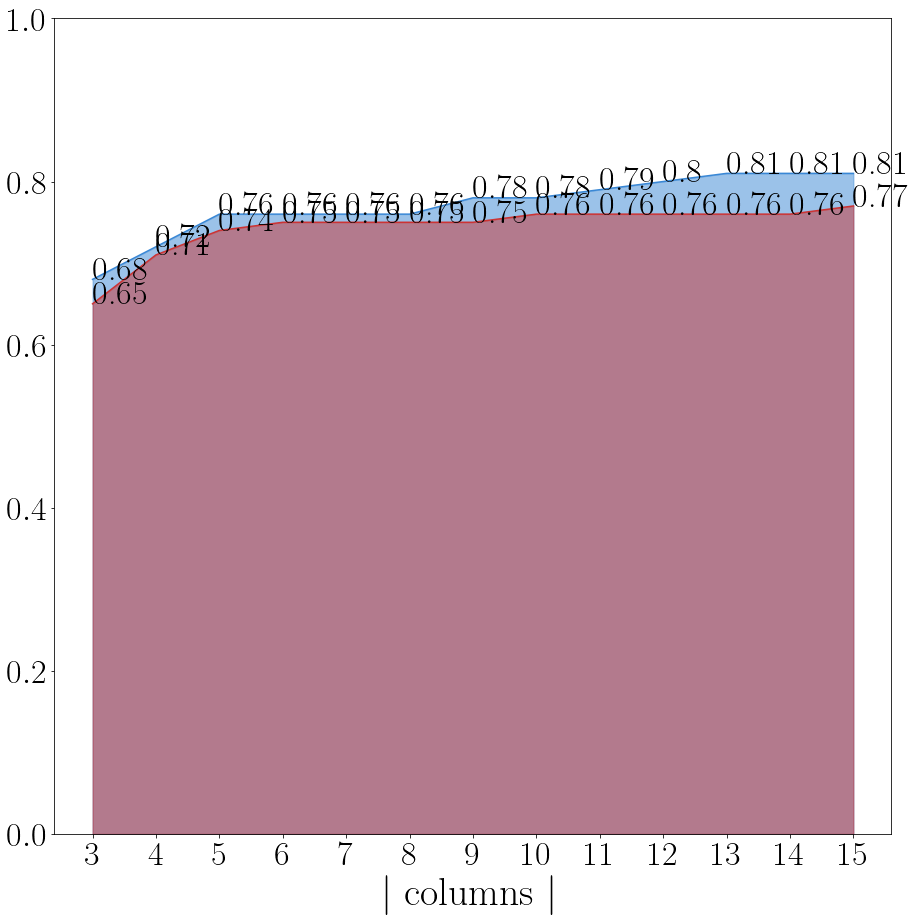

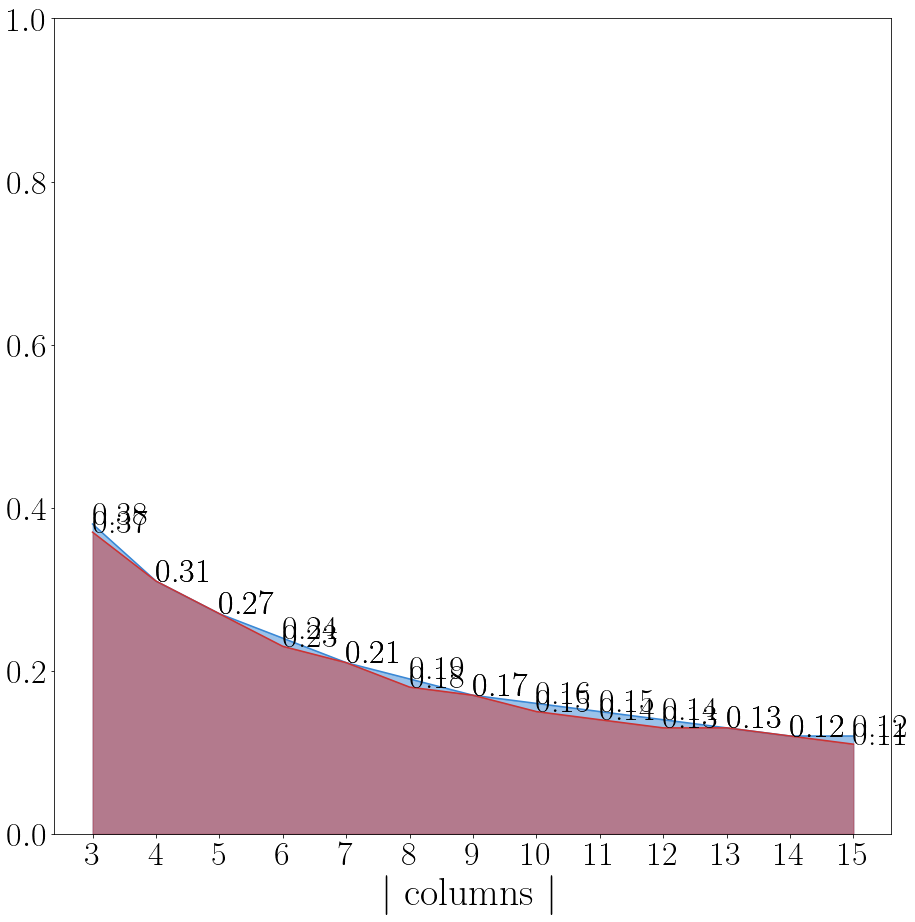

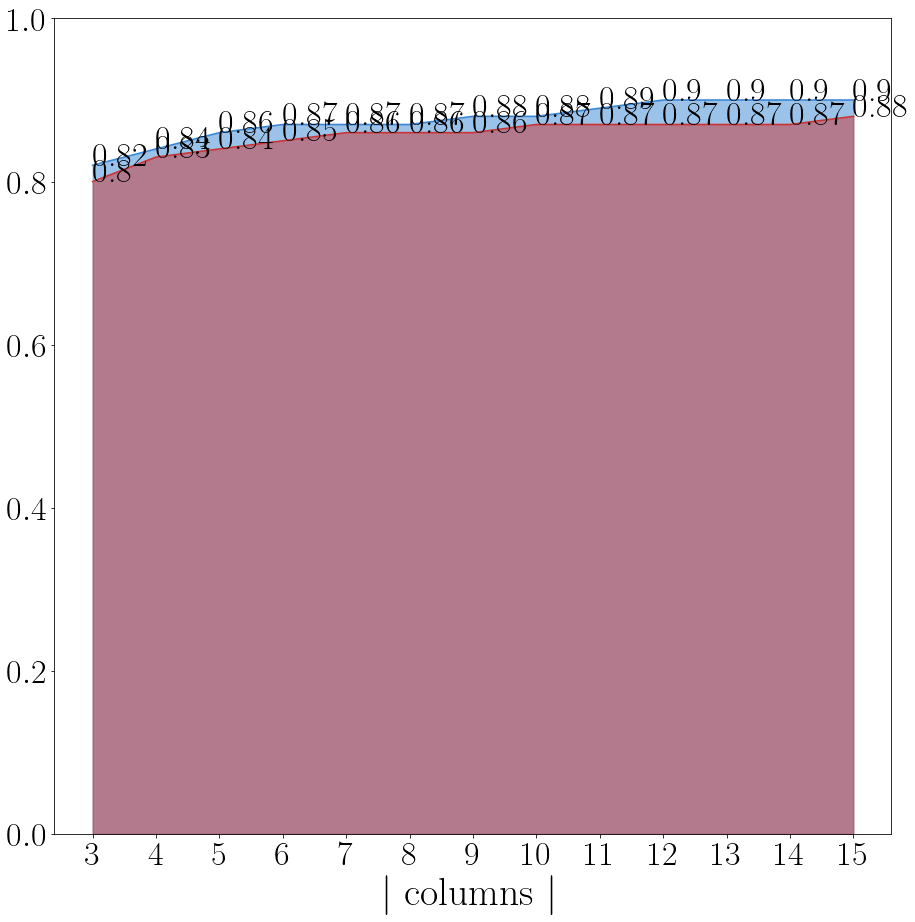

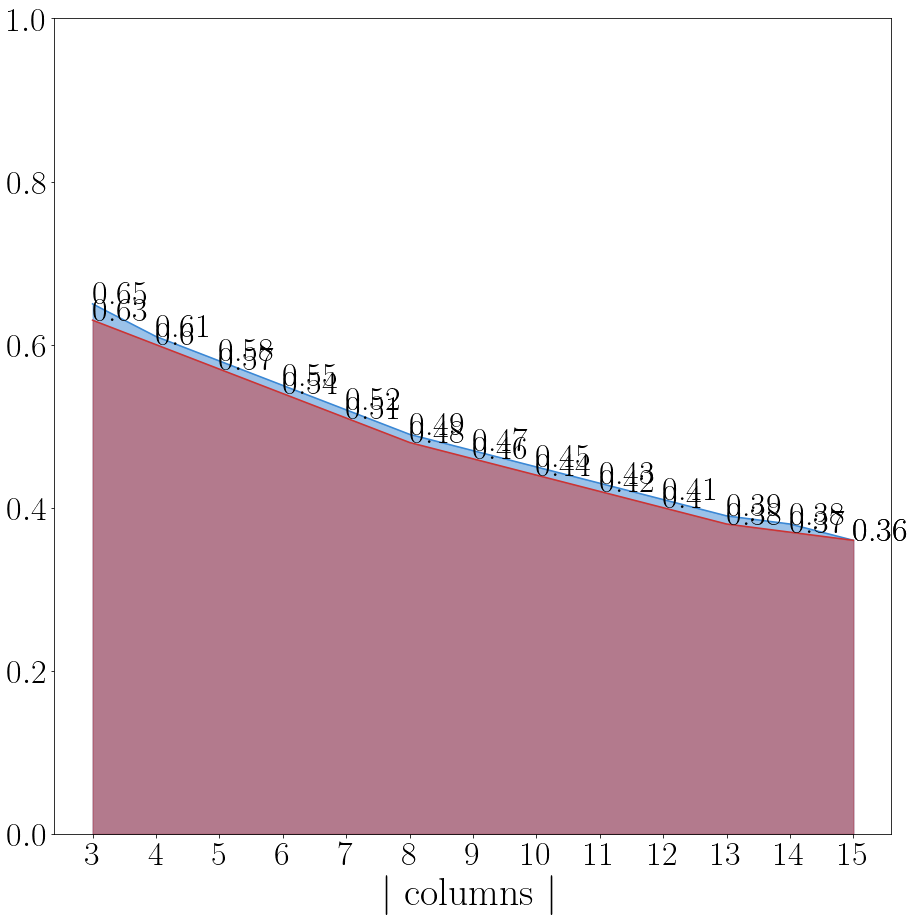

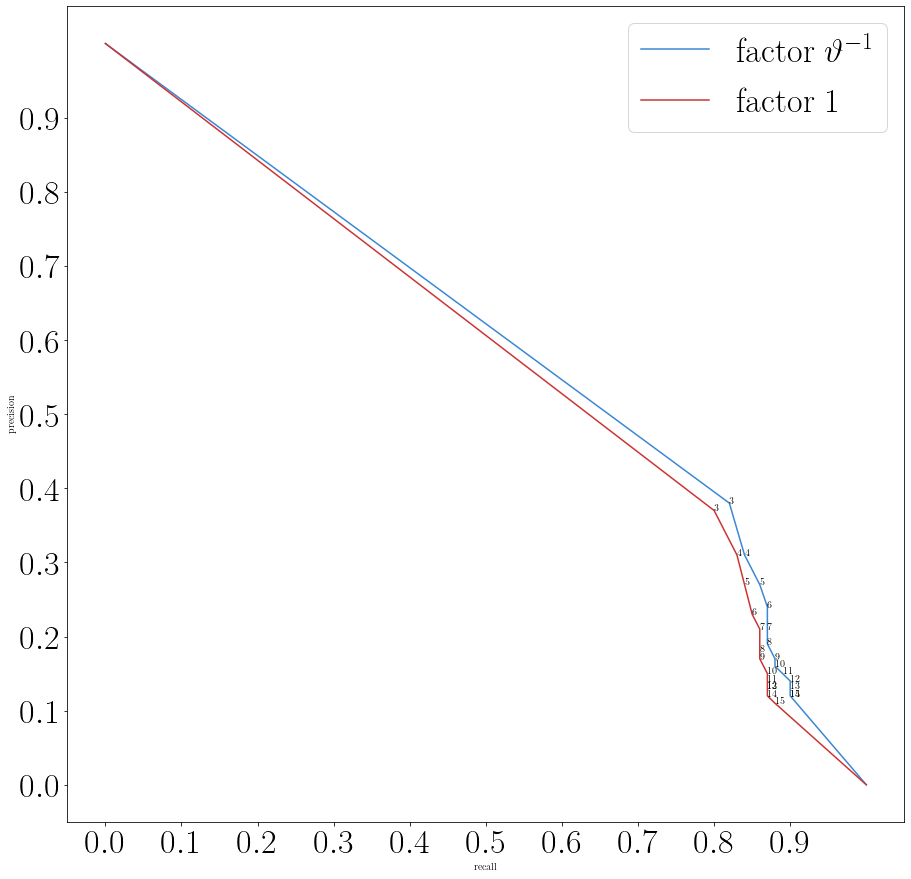

In [5]:
ca_evaluator.column_overview()

In [6]:
#ca_evaluator.eval_all()

### merken:
Histogram anschaubar, um nach Zentralsatz der Grenzwertverteilung (?) zu belegen, dass der mittelwert bei ... liegt (im Konfidenzintervall y)

# TODOS:
- DDIC-Evaluierungen (Tabellenname -> Anzahl Spalten, ...)
- restliche Doc-Strings
- **weitere SAP-Evaluierungsfragen (sap_validation_data.xlsx)**

# DONE:
- Einzelspaltenanalyse (mit Histogramm-Ansicht etc.)
- PR-Curve